# Занятие 6. Логистическая регрессия

**Цель данного занятия** состоит в освоении на практике логистической регрессии на примере задачи классификации фильмов на два класса.

## Данные

Далее **загрузим таблицу** `Netflix.csv`, которая содержит информацию о статьях, опубликованных в различных изданиях. 

Будем решать **задачу бинарной классификации**: по описанию фильмов определять, содержит ли он контент "для взрослых". 

Рейтинги, которые запрещают фильм к просмотру лицам моложе 17-ти лет: `NC-17`, `TV-MA` и `R`.

Сформируем соответсвующие `X` и `Y`:

In [27]:
class_0 = ['TV-14', 'PG-13', 'TV-PG', 'PG', 'TV-G', 'G', 'TV-Y7', 'TV-Y']
class_1 = ['NC-17', 'TV-MA', 'R']

In [2]:
import pandas as pd

table = pd.read_csv('Netflix.csv', index_col=0)

table = table[table['type'] == 'Movie']
table = table[table['rating'].isin(class_0 + class_1)]

X = table['description']
Y = table['rating'].isin(class_1).astype(int).values

Разобъём данные на `train` и `test`:

In [3]:
from sklearn.model_selection import train_test_split

X_train, X_test, Y_train, Y_test = train_test_split(X, Y)

Векторизуем описания фильмов, используя [sklearn.feature_extraction.text.TfidfVectorizer](https://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.TfidfVectorizer.html)

In [4]:
from sklearn.feature_extraction.text import TfidfVectorizer

vectorizer = TfidfVectorizer(max_df=.95, min_df=5)

X_train = vectorizer.fit_transform(X_train).toarray()
X_test = vectorizer.transform(X_test).toarray()

## Логистическая регрессия

Реализуем класс `CustomLogisticRegression`, который будет наследоваться от [sklearn.base.ClassifierMixin](https://scikit-learn.org/stable/modules/generated/sklearn.base.ClassifierMixin.html#sklearn.base.ClassifierMixin), который бы обучал линейную регрессию максимизируя правдоподобие, используя `GD`.

Класс, должен принимать следующие параметры при инициализации:
    
    learning_rate : float : параметр задающий скорось обучения
    fit_intercept : bool : если True, то добавляем свободный член
    max_iter : int : максимальное число эпох
    
и иметь методы `fit`, `predict_proba` и `predict`.

После обучения (запуска метода `fit`) мы должны мочь обратиться к найденным весам модели.

In [32]:
import numpy as np

from sklearn.base import ClassifierMixin

class CustomLogisticRegression(ClassifierMixin):
    def __init__(self, fit_intercept=True, learning_rate=1, max_iter=100):
        self.fit_intercept = fit_intercept
        self.learning_rate = learning_rate
        self.max_iter = max_iter
        
    @staticmethod
    def _add_intercept(X):
        I = np.ones(len(X))[:, np.newaxis]
        X = np.hstack([I, X])
        
        return X
    
    @staticmethod
    def _sigmoid(X):
        return 1 / (1 + np.exp(-X))
    
    def fit(self, X, Y):
        if self.fit_intercept:
            X = CustomLogisticRegression._add_intercept(X)
        
        self.W = np.random.rand(X.shape[1])
        
        Y = Y[:, np.newaxis]
        for _ in range(self.max_iter):
            Y_pred = CustomLogisticRegression._sigmoid(X @ self.W[:, np.newaxis])
            
            self.W += self.learning_rate * ((Y - Y_pred) * X).sum(axis=0)
        
        return self
    
    def predict_proba(self, X):
        
        if self.fit_intercept:
            X = CustomLogisticRegression._add_intercept(X)
            
        return CustomLogisticRegression._sigmoid(X @ self.W[:, np.newaxis]).flatten()
    
    def predict(self, X):
        return (self.predict_proba(X) >= 0.5).astype(np.int32)

In [33]:
import warnings

warnings.filterwarnings('ignore')

lr = CustomLogisticRegression(learning_rate=1)

lr.fit(X_train, Y_train)

Y_pred = lr.predict(X_test)

## Оценка качества

### Accuracy

Реализуем функцY, Y_predию `accuracy(Y, Y_pred)`, которая бы считала долю совпадения меток:

In [34]:
accuracy = lambda Y, Y_pred: (Y == Y_pred).sum() / len(Y)

print(f'Accuracy: {accuracy(Y_test, Y_pred)}')

Accuracy: 0.4973544973544973


In [35]:
print(f'Accuracy: {lr.score(X_test, Y_test)}')

Accuracy: 0.4973544973544973


Модифицируем метод `CustomLogisticRegression.fit` так, чтобы он в атрибут `CustomLogisticRegression.scores` 

сохранял значение *accuracy* после каждой итерации, как на данных для обучения, так и на данных для валидации:

In [9]:
class CustomLogisticRegression(CustomLogisticRegression):
    
    def fit(self, X, Y, validation=None):
        if self.fit_intercept:
            X_ = CustomLogisticRegression._add_intercept(X)
        
        self.W = np.random.rand(X_.shape[1])
        
        self.scores = dict()
        self.scores['train'] = [self.score(X, Y)]
    
        if validation:
            self.scores['val'] = [self.score(*validation)]
        
        Y_ = Y[:, np.newaxis]
        for _ in range(self.max_iter):
            Y_pred = CustomLogisticRegression._sigmoid(X_ @ self.W[:, np.newaxis])
            
            self.W += self.learning_rate * ((Y_ - Y_pred) * X_).sum(axis=0)
            
            self.scores['train'].append(self.score(X, Y))
            
            if validation:
                self.scores['val'].append(self.score(*validation))
        
        return self

In [10]:
lr = CustomLogisticRegression(learning_rate=1)

lr.fit(X_train, Y_train, validation=(X_test, Y_test))

Построем кривые обучения:

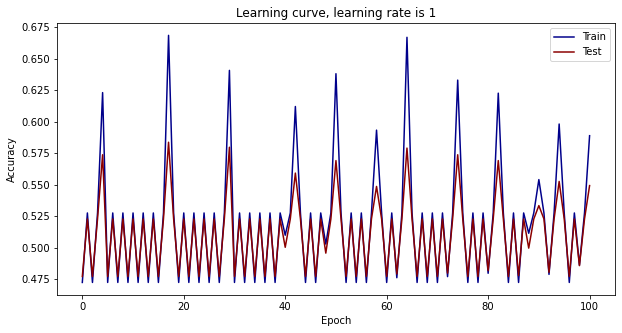

In [11]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 5))
plt.title('Learning curve, learning rate is 1')
plt.plot(lr.scores['train'], color='darkblue', label='Train')
plt.plot(lr.scores['val'], color='darkred', label='Test')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend()
plt.show()

В случае сравнения моделей на тестовой выборке при переборе гиперпараметров, мы можем оказаться в ситуации, когда лучшая на тестовой подвыборке модель не сохраняет свои качества на новых данных. Можно сказать, что происходит *переобучение* на тестовую выборку.

Для устранения описанной выше проблемы, **можно разбить данные на 3 непересекающихся подвыборки: обучение, валидация и тест**. Валидационную подвыборку используют для сравнения моделей, а тестовую — для окончательной оценки качества и сравнения семейств моделей с подобранными гиперпараметрами. 

Произведём такое разбиение:

In [12]:
X_train, X_val, Y_train, Y_val = train_test_split(X, Y)
X_val, X_test, Y_val, Y_test = train_test_split(X_val, Y_val)

X_train = vectorizer.fit_transform(X_train).toarray()
X_val = vectorizer.transform(X_val).toarray()
X_test = vectorizer.transform(X_test).toarray()

print(f'Train {len(Y_train)}, Val {len(Y_val)}, Test {len(Y_test)}')

Train 4532, Val 1133, Test 378


Обучим модели с различным `learning rate` и сравним их кривые обучения на валидациооном датасете:

Searh learning rate: 100%|██████████| 5/5 [00:39<00:00,  7.86s/it]


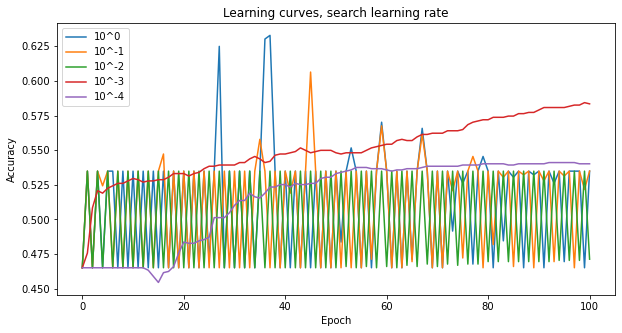

In [13]:
from tqdm import tqdm 

scores = dict()
for learning_rate in tqdm(range(5), desc='Searh learning rate'):
    lr = CustomLogisticRegression(learning_rate=10 ** (-learning_rate))
    lr.fit(X_train, Y_train, validation=(X_val, Y_val))
    
    scores[f'10^{-learning_rate}'] = lr.scores
    
plt.figure(figsize=(10, 5))
plt.title('Learning curves, search learning rate')

for learning_rate, scores in scores.items():
    plt.plot(scores['val'], label=learning_rate)
    
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend()
plt.show()

Посчитаем качество лучшей модели на тестовом датасете:

In [14]:
lr = CustomLogisticRegression(learning_rate=10 ** (-3))

lr.fit(X_train, Y_train)

print(f'Accuracy: {lr.score(X_test, Y_test)}')

Accuracy: 0.5978835978835979


### Precision и recall

Реализуем  функцию `precision_recall(Y, Y_pred)`:

In [15]:
def precision_recall(Y, Y_pred):
    
    TP = (Y & Y_pred).sum()
    FP = (np.abs(Y - 1) & Y_pred).sum()
    FN = (Y & np.abs(Y_pred - 1)).sum()
    
    precision = TP / (TP + FP)
    recall = TP / (TP + FN)
    
    return precision, recall

In [16]:
Y_pred = lr.predict(X_test)

precision, recall = precision_recall(Y_test, Y_pred)

print(f'Precision: {precision}')
print(f'Recall: {recall}')

Precision: 0.5901639344262295
Recall: 0.41379310344827586


In [17]:
from sklearn.metrics import classification_report

print(classification_report(Y_test, Y_pred))

              precision    recall  f1-score   support

           0       0.60      0.75      0.67       204
           1       0.59      0.41      0.49       174

    accuracy                           0.60       378
   macro avg       0.60      0.58      0.58       378
weighted avg       0.60      0.60      0.59       378



### ROC-curve

Реализуем  функцию `roc_curve(Y, Y_pred)`:

In [18]:
def roc_curve(Y, Y_pred):
    
    thresholds = [1 + Y_pred.max()]
    tp_rates = [0]
    fp_rates = [0]

    TP = 0
    FP = 0
    N = (Y == 1).sum()

    indexes = np.argsort(Y_pred)[::-1]
    for y, threshold in zip(Y[indexes],  Y_pred[indexes]):
        TP += (y == 1)
        FP += (y != 1)
        
        tp_rates.append(TP / N)
        fp_rates.append(FP / N)
    
        thresholds.append(threshold)
        
    return fp_rates, tp_rates, thresholds

In [22]:
Y_pred = lr.predict_proba(X_test)

fp_rates, tp_rates, thresholds = roc_curve(Y_test, Y_pred)

Визуализируем ROC-кривую:

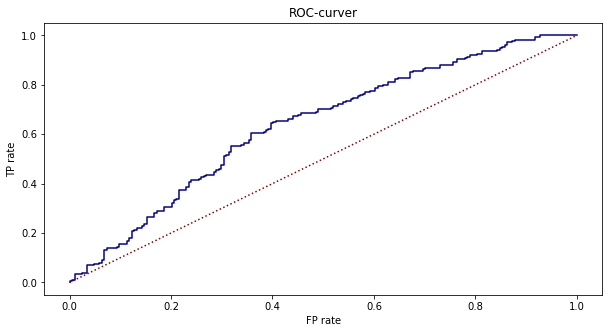

In [23]:
plt.figure(figsize=(10, 5))
plt.title('ROC-curver')
plt.plot(fp_rates, tp_rates, color='darkblue')
plt.plot([0, 1], [0, 1], color='darkred', linestyle='dotted')
plt.xlabel('FP rate')
plt.ylabel('TP rate')
plt.show()

In [ ]:
from sklearn.metrics import roc_curve

fp_rates, tp_rates, thresholds = roc_curve(Y_test, Y_pred)

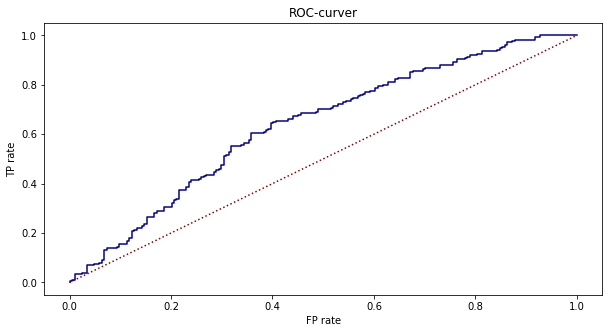

In [24]:
plt.figure(figsize=(10, 5))
plt.title('ROC-curver')
plt.plot(fp_rates, tp_rates, color='darkblue')
plt.plot([0, 1], [0, 1], color='darkred', linestyle='dotted')
plt.xlabel('FP rate')
plt.ylabel('TP rate')
plt.show()